In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

import time

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### AIR POLLUTION MONITORING DATA FROM EDF

In [2]:
    df = pd.read_csv('EDF_Data.csv', header = 1)
    df['TimePeriod'] = 'Jun2015-May2016'
    df.tail()

,Longitude,Latitude,NO Value,NO2 Value,BC Value,TimePeriod
21483,-122.034943,37.560076,129.999995,44.778220,3.923761,Jun2015-May2016
21484,-122.034724,37.560164,60.799998,39.027545,1.408693,Jun2015-May2016
21485,-122.034681,37.559830,34.622951,28.816797,2.659885,Jun2015-May2016
21486,-122.034504,37.559958,74.764705,35.735434,1.776353,Jun2015-May2016
21487,-122.034503,37.559957,78.754782,41.062757,2.014664,Jun2015-May2016


In [3]:
df.shape

(21488, 6)

In [4]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

### Split the dataset into BC and NO2 since we are interested only in those two pollutants

In [5]:
BC_df = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [6]:
NO2_df = df[['Longitude', 'Latitude', 'NO2 Value', 'TimePeriod']]

In [7]:
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

## TRAFFIC DATA

In [8]:
### Load Annual Average Daily Traffic (AADT) file from Caltrans
traffic = pd.read_csv('Data/Traffic_Oakland_AADT.csv', header = 0)

In [9]:
# Drop columns that are unneccessary and choose only Ahead_AADT, along with N/E latitude and longitude
traffic.drop(columns = ['OBJECTID','District','Route','County', 'Postmile', 
                        'Back_pk_h', 'Back_pk_m', 'Ahead_pk_h', 'Ahead_pk_m','Back_AADT','Lat_S_or_W', 'Lon_S_or_W'], inplace=True)

In [10]:
traffic.rename(columns={"Ahead_AADT":"AADT", "Lat_N_or_E":"Latitude", "Lon_N_or_E":"Longitude", "Descriptn":"Description"}, inplace=True)

In [11]:
traffic.head()

,Description,AADT,Latitude,Longitude
0,"ALAMEDA, BROADWAY/ ENCINAL AVENUE",8700,37.760576,-122.240708
1,"ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET",9500,37.770910,-122.263477
2,JCT. RTE. 260 NORTH,0,37.771459,-122.276894
3,"OAKLAND, JCT. RTE. 880",22900,37.769397,-122.221166
4,"OAKLAND, EAST 12TH STREET",16400,37.772068,-122.217378


In [12]:
# Taking a closer look at the traffic data, there are some intersections where the AADT is zero, or the latitude and longitude are zero. We want to drop these rows
traffic = traffic[(traffic['Longitude']<-1) & (traffic['AADT']>1)]

In [13]:
traffic.shape

(71, 4)

## Converting facility and traffic dataframe into a geopandas dataframe for plotting

In [14]:
# Create a geopandas dataframe with traffic data
geometry_traffic = [Point(xy) for xy in zip(traffic['Longitude'], traffic['Latitude'])]
geo_df_traffic = gpd.GeoDataFrame(traffic, crs = crs, geometry = geometry_traffic)

In [15]:
# Create a list of x and y coordinates for the Black Carbon concentration data using geopandas
geometry_df_BC = [Point(xy) for xy in zip(BC_df['Longitude'], BC_df['Latitude'])]
geo_df_BC = gpd.GeoDataFrame(BC_df, crs = crs, geometry = geometry_df_BC)

### Calculate distance between point of measurement and each facility and add it to the _dist column

In [16]:
### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

#### Loading Traffic Data

In [17]:
traffic.head()

,Description,AADT,Latitude,Longitude,geometry
0,"ALAMEDA, BROADWAY/ ENCINAL AVENUE",8700,37.760576,-122.240708,POINT (-122.24071 37.76058)
1,"ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET",9500,37.770910,-122.263477,POINT (-122.26348 37.77091)
3,"OAKLAND, JCT. RTE. 880",22900,37.769397,-122.221166,POINT (-122.22117 37.76940)
4,"OAKLAND, EAST 12TH STREET",16400,37.772068,-122.217378,POINT (-122.21738 37.77207)
6,SAN FRANCISCO/ALAMEDA COUNTY LINE,278000,37.818854,-122.349603,POINT (-122.34960 37.81885)


In [18]:
## Assign an intersection number to each traffic intersection instead of using description
traffic.reset_index(inplace=True)

In [19]:
#Rename index as Intersection
traffic.rename(columns={"index":"Intersection"}, inplace=True)

In [20]:
#Drop the description column
traffic.drop(columns=['Description'], inplace=True)

In [21]:
### Add an empty column for distance
traffic['dist'] = 0
traffic['dist'].astype(float)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
66    0.0
67    0.0
68    0.0
69    0.0
70    0.0
Name: dist, Length: 71, dtype: float64

In [22]:
traffic_lat = traffic[['Intersection', 'Latitude']].T
traffic_long = traffic[['Intersection', 'Longitude']].T
traffic_AADT = traffic[['Intersection', 'AADT']].T
traffic_dist = traffic[['Intersection', 'dist']].T
traffic_geo = traffic[['Intersection', 'geometry']].T


In [23]:
traffic_lat.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
Intersection,0.000000,1.00000,3.000000,4.000000,6.000000,7.000000,8.000000,9.0000,10.000000,11.000000,...,79.000000,80.000000,81.000000,82.000000,83.000000,84.000000,85.000000,91.000000,92.00000,93.00000
Latitude,37.760576,37.77091,37.769397,37.772068,37.818854,37.823843,37.824855,37.8252,37.826401,37.837849,...,37.796197,37.799155,37.802161,37.804525,37.813292,37.815518,37.821345,37.799143,37.80688,37.80949


In [24]:
## Make the header as the first row in each transposed dataframe
traffic_lat = traffic_lat.rename(columns=traffic_lat.iloc[0].astype(int)).drop(traffic_lat.index[0])
traffic_long = traffic_long.rename(columns=traffic_long.iloc[0].astype(int)).drop(traffic_long.index[0])
traffic_AADT = traffic_AADT.rename(columns=traffic_AADT.iloc[0].astype(int)).drop(traffic_AADT.index[0])
traffic_dist = traffic_dist.rename(columns=traffic_dist.iloc[0].astype(int)).drop(traffic_dist.index[0])
traffic_geo = traffic_geo.rename(columns=traffic_geo.iloc[0].astype(int)).drop(traffic_geo.index[0])

In [25]:
## Add suffix to column header based on the dataframe type
traffic_lat.columns = [str(col) + '_latitude' for col in traffic_lat.columns]
traffic_long.columns = [str(col) + '_longitude' for col in traffic_long.columns]
traffic_AADT.columns = [str(col) + '_AADT' for col in traffic_AADT.columns]
traffic_dist.columns = [str(col) + '_traf_dist' for col in traffic_dist.columns]
traffic_geo.columns = [str(col) + '_geo' for col in traffic_geo.columns]

In [26]:
## Remove index for each dataframe
traffic_lat.reset_index(drop=True, inplace=True)
traffic_long.reset_index(drop=True, inplace=True)
traffic_AADT.reset_index(drop=True, inplace=True)
traffic_dist.reset_index(drop=True, inplace=True)
traffic_geo.reset_index(drop=True, inplace=True)

In [27]:
traffic_combined = traffic_lat.join(traffic_long).join(traffic_AADT).join(traffic_dist).join(traffic_geo)


In [28]:
traffic_combined

,0_latitude,1_latitude,3_latitude,4_latitude,6_latitude,7_latitude,8_latitude,9_latitude,10_latitude,11_latitude,...,79_geo,80_geo,81_geo,82_geo,83_geo,84_geo,85_geo,91_geo,92_geo,93_geo
0,37.760576,37.77091,37.769397,37.772068,37.818854,37.823843,37.824855,37.8252,37.826401,37.837849,...,POINT (-122.268861055 37.7961974865),POINT (-122.276314697 37.7991552558),POINT (-122.295484996 37.8021614459),POINT (-122.30272491 37.8045252655),POINT (-122.302016965 37.8132921671),POINT (-122.298635478 37.8155178024),POINT (-122.292823965 37.821344812),POINT (-122.276152929 37.799143267),POINT (-122.277795333 37.80688),POINT (-122.276034999 37.80949)


In [29]:
traffic_combined = traffic_combined.reindex(columns=sorted(traffic_combined.columns))

In [30]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
traffic_combined = traffic_combined.loc[traffic_combined.index.repeat(21488)].reset_index(drop=True)

In [31]:
BC_Traffic = BC_df.join(traffic_combined)

In [32]:
BC_Traffic.head()

,Longitude,Latitude,BC Value,TimePeriod,geometry,0_AADT,0_geo,0_latitude,0_longitude,0_traf_dist,...,93_AADT,93_geo,93_latitude,93_longitude,93_traf_dist,9_AADT,9_geo,9_latitude,9_longitude,9_traf_dist
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,0,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,0,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,0
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,0,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,0,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,0
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,0,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,0,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,0
3,-122.322299,37.805880,0.489898,Jun2015-May2016,POINT (-122.32230 37.80588),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,0,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,0,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,0
4,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,0,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,0,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,0


In [33]:
# Convert distance column to float type
for idx, col in enumerate(BC_Traffic.columns):
        if "_traf_dist" in col:
            BC_Traffic[col] = pd.to_numeric(BC_Traffic[col], downcast="float")


#### Calculate distance between each traffic intersection and point of measurement and store this in the _dist column

In [35]:
for index, row in BC_Traffic.iterrows():
    for idx, col in enumerate(BC_Traffic.columns):
        if "_traf_dist" in col: 
            BC_Traffic.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx-2], row.iloc[idx-1])))*0.621
            #BC_Facility_Traffic.at[index,col] = float(row.iloc[idx])



In [37]:
BC_Traffic.head()

,Longitude,Latitude,BC Value,TimePeriod,geometry,0_AADT,0_geo,0_latitude,0_longitude,0_traf_dist,...,93_AADT,93_geo,93_latitude,93_longitude,93_traf_dist,9_AADT,9_geo,9_latitude,9_longitude,9_traf_dist
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,5.490889,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,2.546934,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,1.606228
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,5.453057,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,2.535095,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,1.631727
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,5.463431,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,2.532960,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,1.616419
3,-122.322299,37.805880,0.489898,Jun2015-May2016,POINT (-122.32230 37.80588),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,5.441822,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,2.536256,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,1.646442
4,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),8700,POINT (-122.240707602 37.760576391),37.760576,-122.240708,5.472706,...,140700,POINT (-122.276034999 37.80949),37.80949,-122.276035,2.529637,157500,POINT (-122.304611578 37.825200142),37.8252,-122.304612,1.600457


In [38]:
#### Write this to a dataframe
BC_Traffic.to_csv("Data/BC_Traffic_ALL.csv")

#### Similar to the facility dataframe, drop latitude and longitude since its captured in the distance column. Also drop AADT

In [39]:
BC_Traffic.drop(list(BC_Traffic.filter(regex = '_latitude')), axis = 1, inplace = True)
BC_Traffic.drop(list(BC_Traffic.filter(regex = '_longitude')), axis = 1, inplace = True)
BC_Traffic.drop(list(BC_Traffic.filter(regex = '_AADT')), axis = 1, inplace = True)
BC_Traffic.drop(list(BC_Traffic.filter(regex = '_geo')), axis = 1, inplace = True)
BC_Traffic.drop(list(BC_Traffic.filter(regex = 'Longitude')), axis = 1, inplace = True)
BC_Traffic.drop(list(BC_Traffic.filter(regex = 'Latitude')), axis = 1, inplace = True)
BC_Traffic.drop(list(BC_Traffic.filter(regex = 'TimePeriod')), axis = 1, inplace = True)

In [41]:
BC_Traffic.drop(list(BC_Traffic.filter(regex = 'geometry')), axis = 1, inplace = True)

In [42]:
BC_Traffic.head()

,BC Value,0_traf_dist,10_traf_dist,11_traf_dist,12_traf_dist,13_traf_dist,14_traf_dist,15_traf_dist,16_traf_dist,17_traf_dist,...,81_traf_dist,82_traf_dist,83_traf_dist,84_traf_dist,85_traf_dist,8_traf_dist,91_traf_dist,92_traf_dist,93_traf_dist,9_traf_dist
0,0.818032,5.490889,1.857035,2.577255,3.188756,8.065185,7.731380,7.522881,6.825096,6.380071,...,1.513019,1.095130,1.209259,1.439541,1.910168,1.528555,2.588098,2.444070,2.546934,1.606228
1,0.551475,5.453057,1.878675,2.605197,3.222432,8.041680,7.711190,7.504289,6.811504,6.372018,...,1.489227,1.074394,1.211965,1.444476,1.920473,1.555640,2.564378,2.429110,2.535095,1.631727
2,0.593712,5.463431,1.864487,2.589262,3.205112,8.044722,7.712720,7.505108,6.810163,6.368392,...,1.492296,1.076002,1.204029,1.435762,1.909917,1.539898,2.567468,2.428288,2.532960,1.616419
3,0.489898,5.441822,1.892194,2.620559,3.239318,8.037590,7.708599,7.502406,6.811784,6.374599,...,1.485292,1.072000,1.219121,1.452382,1.930219,1.570824,2.560329,2.428963,2.536256,1.646442
4,0.739341,5.472706,1.849545,2.572713,3.187360,8.046475,7.712956,7.504634,6.807542,6.363515,...,1.494264,1.076594,1.195133,1.426073,1.898406,1.523542,2.569361,2.426274,2.529637,1.600457


In [43]:
corr = BC_Traffic.corr()

In [44]:
arr_corr = corr.as_matrix()

/home/shridhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [45]:
arr_corr[0]

array([1.        , 0.19286704, 0.14048825, 0.1481266 , 0.15151856,
       0.2968593 , 0.29874521, 0.29600929, 0.27405315, 0.25249537,
       0.23401692, 0.22068255, 0.15811996, 0.21588757, 0.17450787,
       0.16062966, 0.15331016, 0.16753324, 0.17687499, 0.19610851,
       0.21575361, 0.22421517, 0.15563827, 0.15945743, 0.16060027,
       0.1421487 , 0.14163186, 0.14109571, 0.22247227, 0.28064083,
       0.29108034, 0.29616425, 0.29623985, 0.28287424, 0.27916691,
       0.26493105, 0.23179254, 0.24908063, 0.2377686 , 0.20859766,
       0.20030679, 0.18203354, 0.17817095, 0.17810309, 0.16772403,
       0.1549663 , 0.15037808, 0.147268  , 0.25731685, 0.23997467,
       0.23981025, 0.1320826 , 0.12027528, 0.22627333, 0.19499909,
       0.18814036, 0.17226684, 0.15940066, 0.15064871, 0.14871716,
       0.13085351, 0.14353389, 0.12906994, 0.12483012, 0.13031099,
       0.13459533, 0.14330021, 0.13503947, 0.14366685, 0.14843865,
       0.15228854, 0.13629777])

#### Plotting correlation between all features as a heatmap - but this visualization is not easy to follow....

fig, ax = plt.subplots(figsize=(100, 100))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=500),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

module://ipykernel.pylab.backend_inline


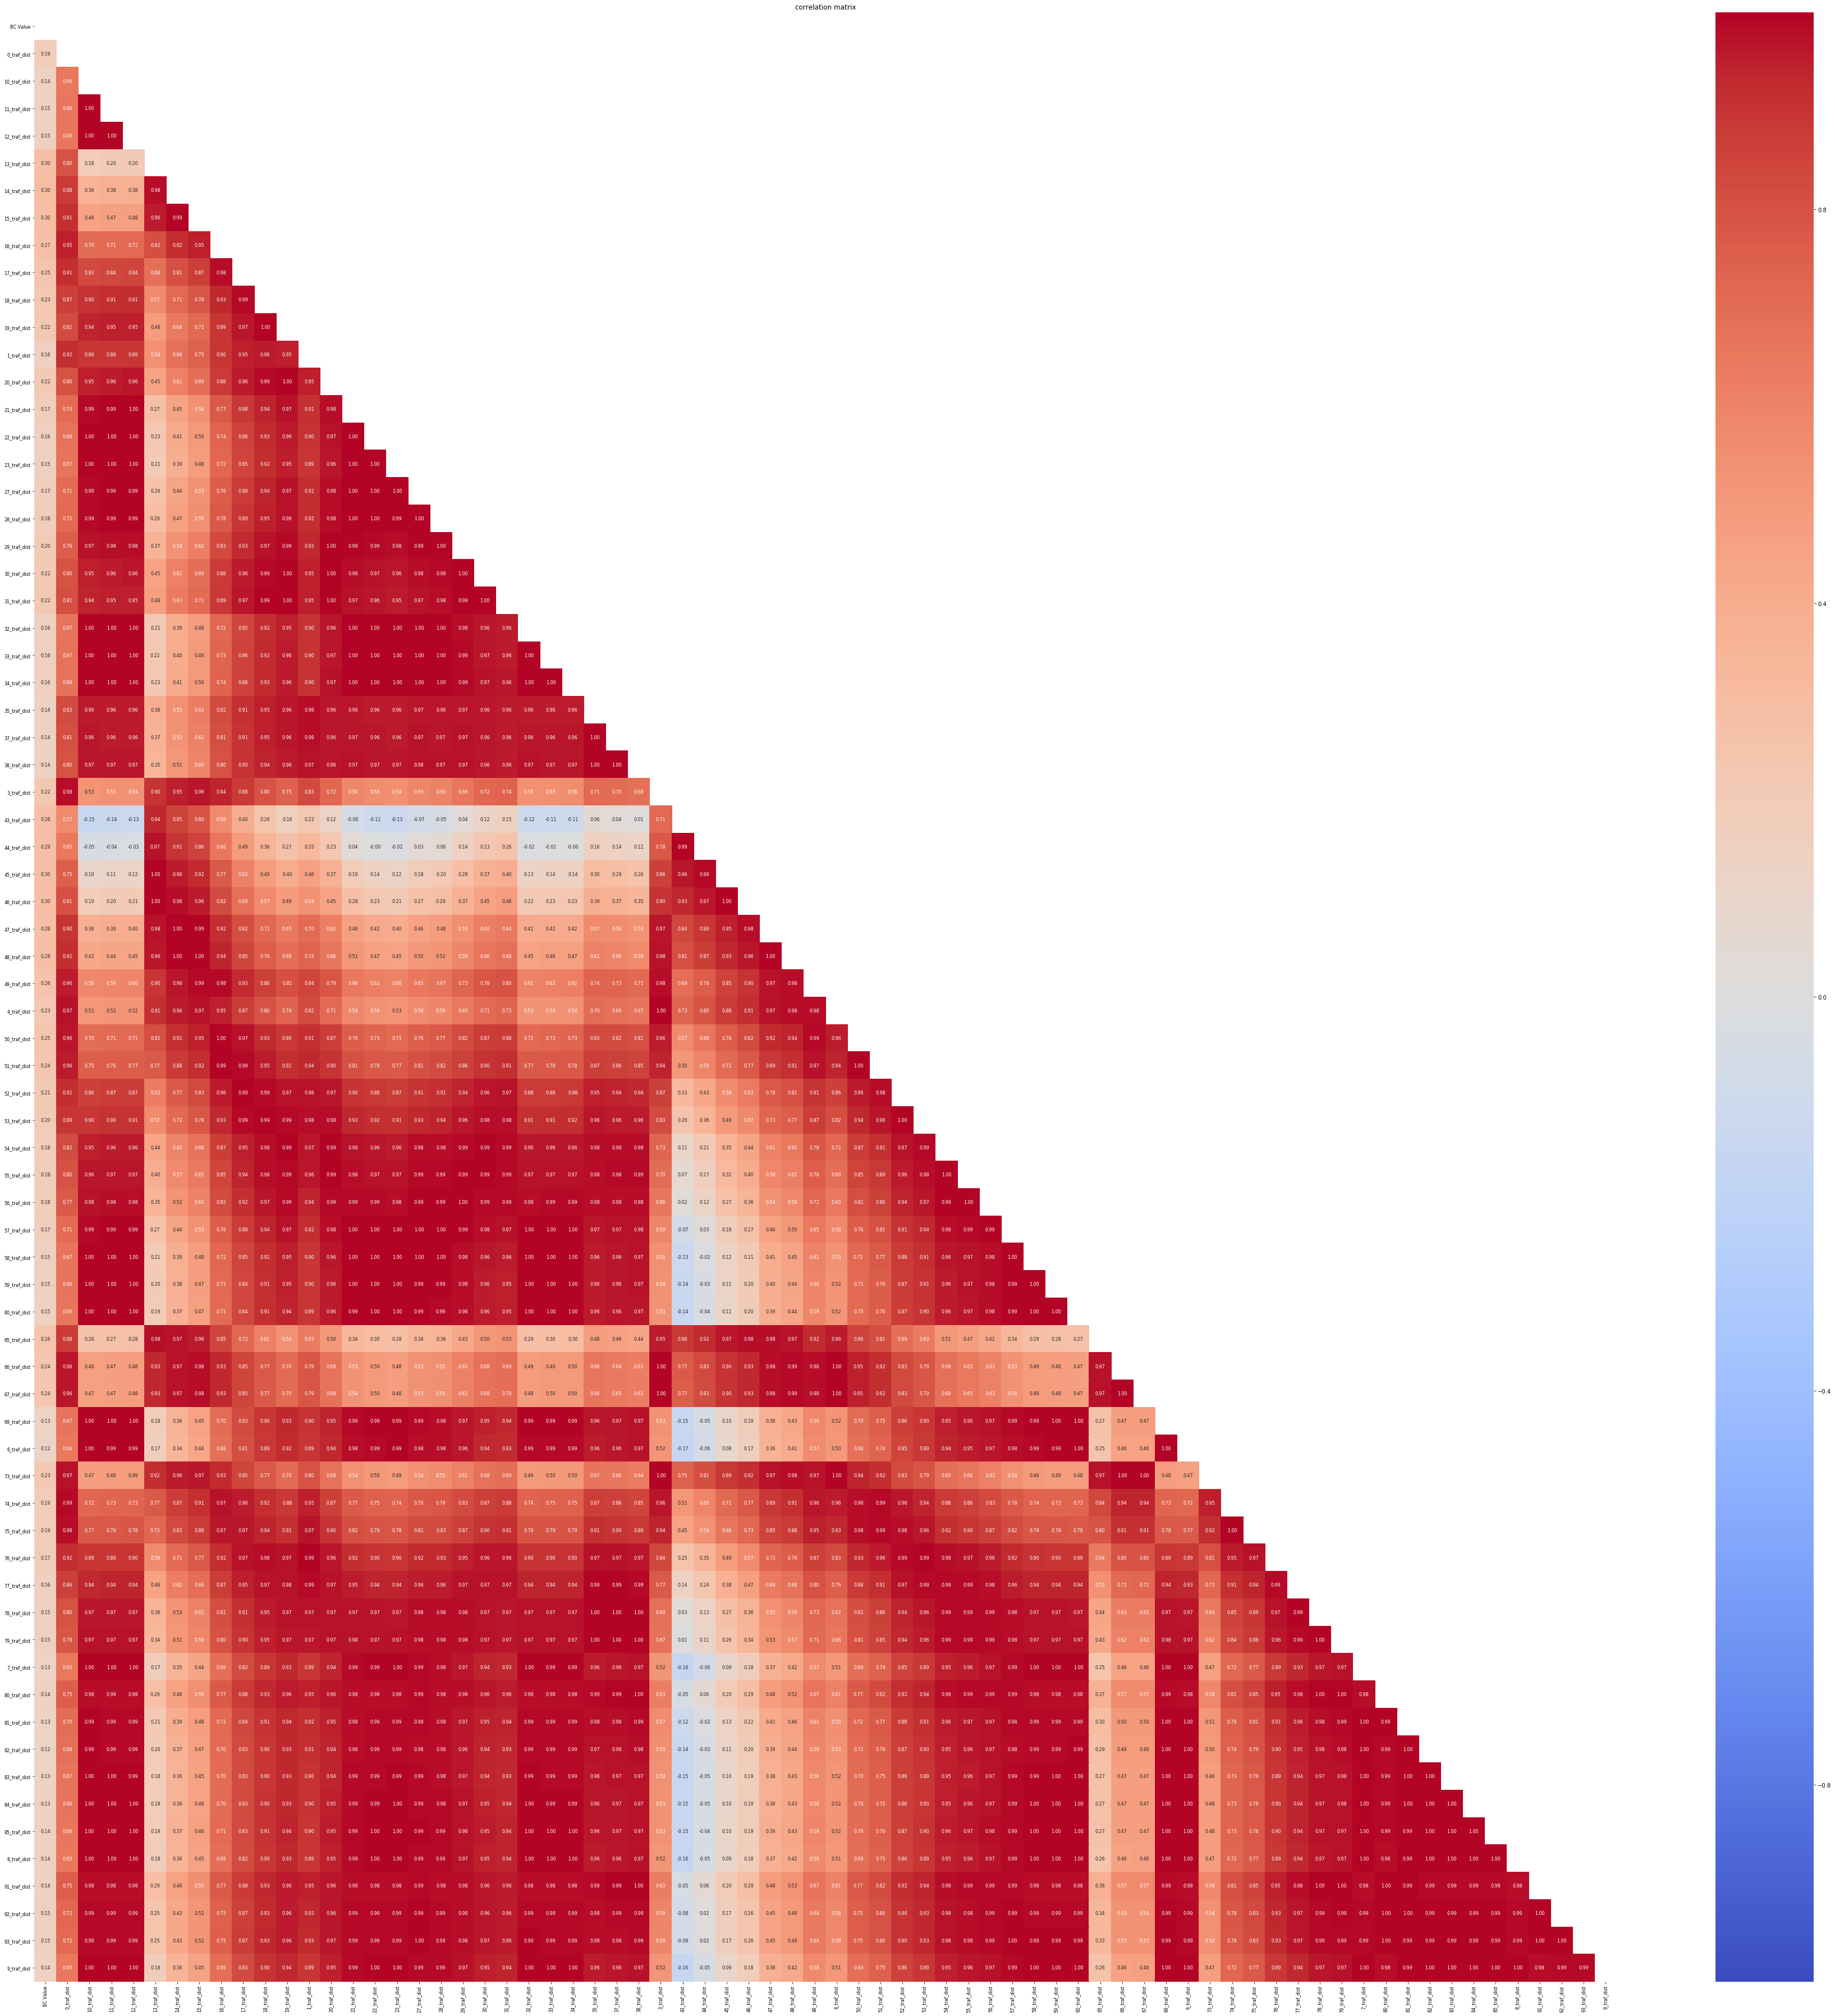

In [46]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
arr_corr[np.triu_indices_from(arr_corr)] = np.nan

fig, ax = plt.subplots(figsize=(50, 50))

hm = sns.heatmap(arr_corr, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix')
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

#### Once again there doesn't seem to be much correlation between BC concentrations and the closest major traffic intersection. Next option is to identify all the traffic intersections in the area.



import chart_studio.plotly as py
import plotly.graph_objs as go

import chart_studio
chart_studio.tools.set_credentials_file(username='varsha2509', api_key='QLfBsWWLPKoLjY5hW0Fu')


heatmap = go.Heatmap(z=arr_corr, x=BC_Facility_Traffic_Met.columns, y=BC_Facility_Traffic_Met.index)
data = [heatmap]
py.iplot(data, filename='basic-heatmap')
